In [1]:
import os
import json
from copy import deepcopy
import torch
import transformers
import datasets

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
# import a reference dataset, we can match properties of our dataset with this reference set
data_ref = datasets.load_dataset('ncbi_disease')

Reusing dataset ncbi_disease (/Users/vijetadeshpande/.cache/huggingface/datasets/ncbi_disease/ncbi_disease/1.0.0/92314c7992b0b8a5ea2ad101be33f365b684a2cc011e0ffa29c691e6d32b2d03)


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
# explore reference data
data_ref['train']

Dataset({
    features: ['id', 'tokens', 'ner_tags'],
    num_rows: 5433
})

In [4]:
data_ref['train'][0]

{'id': '0',
 'tokens': ['Identification',
  'of',
  'APC2',
  ',',
  'a',
  'homologue',
  'of',
  'the',
  'adenomatous',
  'polyposis',
  'coli',
  'tumour',
  'suppressor',
  '.'],
 'ner_tags': [0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0]}

In [5]:
# we want name of our X to be 'tokens' and Y as 'ner_tags'
# lets import our data
filepath = r'/Users/vijetadeshpande/Downloads/UMass Lowell - Courses/Spring 2022/Foundations in Digital Health/FDigital_Health_Spring_2022/Project_final/Data/preprocessed_data_95%.json'
with open(filepath, 'r') as f:
    data = json.load(f)


In [6]:
# structure of our dataset
# data = {'id': dict}
# data[id] = {'sentences': list}
# data[id][index] = {'words': [], labels_sbdh: [], labels_umls: []}

# so, every data[id][index] has the proper shape that we want. Let's collect all in one dict

data_ = {'train': []}
for i in data:
    for j in data[i]:
        if j == 'sequences':
            for instance in data[i][j]:
                instance['id'] = i
                data_['train'].append(deepcopy(instance))

In [7]:
data_['train'][100]

{'words': ['He', 'tolerated', 'the', 'surgery', 'well.'],
 'labels_sbdh': ['O', 'O', 'O', 'O', 'O'],
 'labels_umls': ['O', 'O', 'O', 'O', 'O'],
 'id': '10065'}

In [8]:
# eda
sample_size = len(data_['train'])
sample_size_pos = 0 # sentences having sbdh entities
sample_size_neg = 0 # sentences not having any sbdh entities
sample_pos = []
sample_neg = []

for i, instance in enumerate(data_['train']):
    sample_instance = instance
    y = instance['labels_sbdh'] 
    if y == ['O'] * len(y):
        sample_size_neg += 1
        sample_neg.append((i, instance['id']))
    else:
        sample_size_pos += 1
        sample_pos.append((i, instance['id']))

assert len(sample_pos) == sample_size_pos
assert len(sample_neg) == sample_size_neg
print(sample_size_pos)
print(sample_size_neg)
print((sample_size_pos + sample_size_neg) == sample_size)

13006
856870
True


# what are the things we will need to do?

1. Check length distribution for the positive and negative sentences
    1.1. might need to remove too short sentences
2. As Avijit mentioned, it'll be helpful to have some context for the sentences
    2.1. maybe 2 sentences before + tagged sentence + 2 senteces after, could be helpful
    


10th, 25th, 50th, 75th, 90th percentiles for positive examples:
[ 5.  7. 12. 18. 26.]
Mean value of length for positive sentences:
13.913578348454559

10th, 25th, 50th, 75th, 90th percentiles for neg examples:
[ 3.  5. 10. 17. 27.]
Mean value of length for negative sentences:
13.52480656342269


(array([8.5513e+05, 1.4870e+03, 1.7300e+02, 4.5000e+01, 2.3000e+01,
        4.0000e+00, 3.0000e+00, 2.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([1.0000e+00, 1.3310e+02, 2.6520e+02, 3.9730e+02, 5.2940e+02,
        6.6150e+02, 7.9360e+02, 9.2570e+02, 1.0578e+03, 1.1899e+03,
        1.3220e+03]),
 <BarContainer object of 10 artists>)

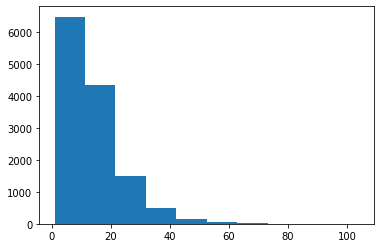

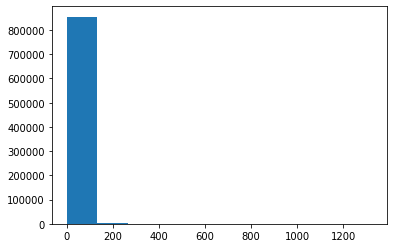

In [9]:
# check length distribution
length_pos = []
length_neg = []

for i, id_ in sample_pos:
    instance = data_['train'][i]
    if instance['id'] == id_:
        length_pos.append(len(instance['words']))

for i, id_ in sample_neg:
    instance = data_['train'][i]
    if instance['id'] == id_:
        length_neg.append(len(instance['words']))




print('\n10th, 25th, 50th, 75th, 90th percentiles for positive examples:')
print(np.percentile(length_pos, (10, 25, 50, 75, 90)))
print('Mean value of length for positive sentences:')
print(np.mean(length_pos))

print('\n10th, 25th, 50th, 75th, 90th percentiles for neg examples:')
print(np.percentile(length_neg, (10, 25, 50, 75, 90)))
print('Mean value of length for negative sentences:')
print(np.mean(length_neg))

# distribution of sequence length does not differ much.
# This is good. So, based on input sequence length, 
# model won't be able to tell whether the input sequnce is a positive sentence or negative sentence
# We can set the maximum word-length of all sequence to 100 (maybe)


#
plt.figure()
plt.hist(length_pos, bins=10)

plt.figure()
plt.hist(length_neg, bins=10)


In [10]:
# check sbdh label distribution
unique_cat = set()
for instance in data_['train']:
    unique_cat = unique_cat.union(set(instance['labels_sbdh']))
unique_cat = sorted(list(unique_cat))

label_to_idx = {}
for idx, label in enumerate(unique_cat):
    label_to_idx[label] = idx
print(label_to_idx)


{'O': 0, 'behavior_alcohol': 1, 'behavior_drug': 2, 'behavior_tobacco': 3, 'sdoh_community': 4, 'sdoh_economics': 5, 'sdoh_education': 6, 'sdoh_environment': 7}


([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

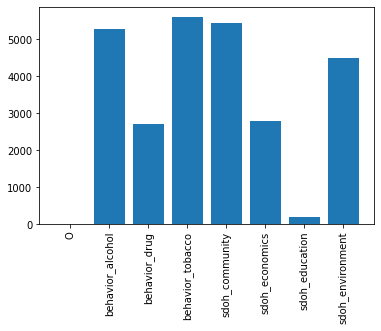

In [11]:
#
sbdh_dist = {} # within positive sentences
for label in label_to_idx:
    sbdh_dist[label] = 0

for instance in data_['train']:
    y_unique = set(instance['labels_sbdh'])
    for y in y_unique:
        if not y == 'O':
            sbdh_dist[y] += 1

#
plt.figure()
plt.bar(list(sbdh_dist.keys()), list(sbdh_dist.values()))
plt.xticks(rotation = 90)

# therefore, we might need to over sample behavior_drug, sdoh_economics, sdoh_education

(array([2.181372e+06, 3.355766e+06, 2.078344e+06, 1.894550e+06,
        1.557041e+06, 3.665350e+05, 2.127100e+05, 8.056900e+04,
        2.341200e+04, 1.046800e+04, 3.381000e+03, 3.222000e+03,
        9.340000e+02, 7.650000e+02, 9.000000e+01, 8.400000e+01,
        4.200000e+01, 5.200000e+01, 2.000000e+01, 2.500000e+01,
        2.400000e+01, 2.000000e+01, 2.500000e+01, 9.000000e+00,
        1.000000e+01, 3.780000e+02, 2.200000e+01, 6.000000e+00,
        8.100000e+01, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.00

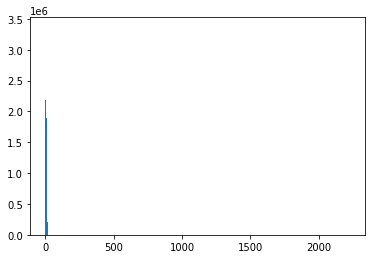

In [12]:
# check length of the words

word_lengths = []
for instance in data_['train']:
    for word in instance['words']:
        word_lengths.append(len(word))


plt.figure()
plt.hist(word_lengths, bins=1000)

In [13]:
sorted_word_lengths = sorted(word_lengths, reverse=False)
sorted_word_lengths[-10:]



w_len_dict = {}
for instance in data_['train']:
    for word in instance['words']:
        len_ = len(word)
        if not len_ in w_len_dict:
            w_len_dict[len_] = [word]
        else:
            w_len_dict[len_].append(word)



In [14]:
#
unique_len = sorted(w_len_dict.keys())

w_len_dict[40]

['========================================',
 'cough/sob/cp/orthopnea/pnd/fever/chills.',
 'dysuria/hematuria/diarrhea/melana/BRBPR.',
 'Lives in [**Location 2268**] by herself.',
 '========================================',
 'x3(Lima-LAD/SVG->OM/PDA)-[**2121-2-14**]',
 '**]-bos-bor;<br>glucosam-chondroitin-vit',
 '**]-bos-bor;<br>glucosam-chondroitin-vit',
 '========================================',
 '========================================',
 '========================================',
 '========================================',
 '========================================',
 '========================================',
 '========================================']

In [15]:
sbdh_dist

data_['train'][0].keys()

dict_keys(['words', 'labels_sbdh', 'labels_umls', 'id'])

In [16]:
# data tokenization
from transformers import AutoTokenizer, PreTrainedTokenizer

# 
model_name = 'bert-base-uncased'

# define tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [17]:
def extend_label(tokens, label):
    label = str(label)
    
    if len(tokens) >= 2:
        if label != 'O':
            label_b = label + '_B'
            label_i = label + '_I'
            labels = [label_b] + [label_i] * (len(tokens)-1)            
        else:
            labels = ['O'] * len(tokens)
    elif len(tokens) == 1:
        labels = [label]
    elif len(tokens) == 0:
        labels = []
    
    #
    if not len(tokens) == len(labels):
        print(tokens)
        print(labels)
    
    return labels

In [18]:
def separation_string(char_, length):
    
    list_ = [char_] * length
    str_ = ''.join(list_)
    
    return str_

def is_ignore(w):
    
    #
    if len(w) > 40:
        return True
    
    if len(w) > 10:
        special_chars = ['.', '=', '-', '_', ',']
        for schar in special_chars:
            if w == separation_string(schar, len(w)):
                return True
    
    return False

In [19]:


#
data_tok = {}
problematic_words = []
ignored_examples = []
selected_examples = []
for subset in data_:
    data_tok[subset] = []
    
    for example in tqdm(data_[subset]):
        x_ = []
        y_sbdh = []
        y_umls = []
        append_ = True
        for idx, word in enumerate(example['words']):
            ignore_word = is_ignore(word)
            
            if not ignore_word:
                tokens = tokenizer.tokenize(word)

                #if (len(tokens) >= 10) and (example['labels_sbdh'][idx] == 'O'):
                #    continue

                if (len(tokens) >= 30) and (example['labels_sbdh'][idx] != 'O'):
                    problematic_words.append(example)


                bio_sbdh = extend_label(tokens, example['labels_sbdh'][idx])
                bio_umls = extend_label(tokens, example['labels_umls'][idx])

                #
                x_ += tokens
                y_sbdh += bio_sbdh
                y_umls += bio_umls
            
            else:
                append_ = False
                ignored_examples.append(example)
                break
    
        #
        if append_:
            selected_examples.append(example)
            tokenized_instance = {
                'tokens': x_,
                'labels_sbdh': y_sbdh,
                'labels_umls': y_umls
            }
            data_tok[subset].append(deepcopy(tokenized_instance))

100%|█████████████████████████████████| 869876/869876 [08:37<00:00, 1681.20it/s]


In [20]:
ignored_pos = []
for example in ignored_examples:
    y_ = example['labels_sbdh']
    if not y_ == ['O'] * len(y_):
        print('\n')
        print(example)
        ignored_pos.append(example)

#
len(ignored_pos)




{'words': ['Contact:', 'Mother,', '[**Telephone/Fax', '(1)', '8064**].', 'PCP:', '....................', '.'], 'labels_sbdh': ['O', 'sdoh_community', 'O', 'O', 'O', 'O', 'O', 'O'], 'labels_umls': ['O', 'C0237094', 'O', 'O', 'O', 'O', 'O', 'O'], 'id': '1308'}


{'words': ["Retired.\n\n\nFamily History:\nNon-contributory\n\n\nPhysical Exam:\nPE on Admission:\nVS: afebrile HR 70's BP: 140-170's / 60's RR: 16\nGen: NAD, AOx3\nNeck: Trachea midline, neck supple. Palpable carotid pulses\nCVS: RRR, no M/R/G\nPulm: no resp distress\nAbd: S/ND/min TTP to deep palpation.  Pulsatile mass upper\nabdomen consistent with known AAA\nLE: no LLE edema, warm, lack of hair distal LE bilaterally\nPulse:\nRLE: Femoral palpable DP/PT: -/dop\nLLE: Femoral palpable DP/PT: P/dop\n\n\nPertinent Results:\n[**2153-2-22**] 02:37AM BLOOD WBC-8.5 RBC-3.12* Hgb-8.8* Hct-28.8*\nMCV-92 MCH-28.3 MCHC-30.7* RDW-14.9 Plt Ct-341\n[**2153-1-27**] 07:00AM BLOOD WBC-9.7 RBC-3.78* Hgb-11.7* Hct-32.1*\nMCV-85 MCH-31.1 MCHC-36

11

In [21]:
len(selected_examples)

868772

In [22]:
selected_pos, selected_neg = [], []
for example in selected_examples:
    y_ = example['labels_sbdh']
    if y_ == ['O'] * len(y_):
        selected_neg.append(example)
    else:
        selected_pos.append(example)

In [23]:
pos_lengths, neg_lengths = [], []
for pos_ in selected_pos:
    pos_lengths.append(len(pos_['words']))

for neg_ in selected_neg:
    neg_lengths.append(len(neg_['words']))


print('\n10th, 25th, 50th, 75th, 90th percentiles for positive examples:')
print(np.percentile(pos_lengths, (10, 25, 50, 75, 90)))
print('Mean value of length for positive sentences:')
print(np.mean(pos_lengths))

print('\n10th, 25th, 50th, 75th, 90th percentiles for neg examples:')
print(np.percentile(neg_lengths, (10, 25, 50, 75, 90)))
print('Mean value of length for negative sentences:')
print(np.mean(neg_lengths))


10th, 25th, 50th, 75th, 90th percentiles for positive examples:
[ 5.  7. 12. 18. 26.]
Mean value of length for positive sentences:
13.9049634474798

10th, 25th, 50th, 75th, 90th percentiles for neg examples:
[ 3.  5. 10. 17. 27.]
Mean value of length for negative sentences:
13.489099379861809


([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

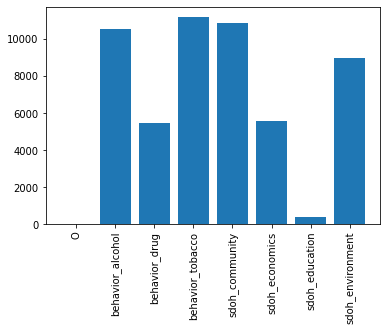

In [24]:
for instance in selected_pos:
    y_unique = set(instance['labels_sbdh'])
    for y in y_unique:
        if not y == 'O':
            sbdh_dist[y] += 1

#
plt.figure()
plt.bar(list(sbdh_dist.keys()), list(sbdh_dist.values()))
plt.xticks(rotation = 90)

# over sampling of
# drug
# economics
# education

In [25]:
selected_pos_add = []
for example in tqdm(selected_pos):
    
    if 'sdoh_education' in example['labels_sbdh']:
        for i in range(20):
            selected_pos_add.append(example)
        continue
    
    if 'sdoh_economics' in example['labels_sbdh']:
        for i in range(2):
            selected_pos_add.append(example)
        continue
    
    if 'behavior_drug' in example['labels_sbdh']:
        for i in range(2):
            selected_pos_add.append(example)
        continue

100%|█████████████████████████████████| 12995/12995 [00:00<00:00, 647104.68it/s]


In [26]:
selected_pos += selected_pos_add
print(type(selected_pos))

<class 'list'>


([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

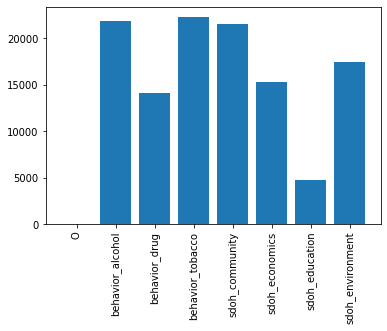

In [27]:
# adjusted data
for instance in selected_pos:
    y_unique = set(instance['labels_sbdh'])
    for y in y_unique:
        if not y == 'O':
            sbdh_dist[y] += 1

#
plt.figure()
plt.bar(list(sbdh_dist.keys()), list(sbdh_dist.values()))
plt.xticks(rotation = 90)

In [28]:
# sample equal amount of negative examples
sampled_neg = list(np.random.choice(selected_neg, len(selected_pos)))


In [29]:
# check length distribution of both sets

pos_lengths, neg_lengths = [], []
for pos_ in selected_pos:
    pos_lengths.append(len(pos_['words']))

for neg_ in sampled_neg:
    neg_lengths.append(len(neg_['words']))


print('\n10th, 25th, 50th, 75th, 90th percentiles for positive examples:')
print(np.percentile(pos_lengths, (10, 25, 50, 75, 90)))
print('Mean value of length for positive sentences:')
print(np.mean(pos_lengths))

print('\n10th, 25th, 50th, 75th, 90th percentiles for neg examples:')
print(np.percentile(neg_lengths, (10, 25, 50, 75, 90)))
print('Mean value of length for negative sentences:')
print(np.mean(neg_lengths))



10th, 25th, 50th, 75th, 90th percentiles for positive examples:
[ 5.  8. 13. 20. 29.]
Mean value of length for positive sentences:
15.361140912285894

10th, 25th, 50th, 75th, 90th percentiles for neg examples:
[ 3.  5. 10. 16. 26.]
Mean value of length for negative sentences:
13.33420887129592


In [30]:
# combine, suffle and save the data
type(selected_pos)
type(list(sampled_neg))

data_save = selected_pos + sampled_neg

In [31]:
from random import shuffle
shuffle(data_save)

In [32]:
from sklearn.model_selection import train_test_split

#
X = []
y = []
for example in data_save:
    X.append({'words': example['words']})
    y.append({'labels_sbdh': example['labels_sbdh'], 'labels_umls': example['labels_umls']})

# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# split the new train into train and val
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [33]:

data_final = {'train': [], 'validation': [], 'test': []}

for idx, example in enumerate(X_train):
    instance = {**example, **y_train[idx]}
    data_final['train'].append(instance)

for idx, example in enumerate(X_val):
    instance = {**example, **y_val[idx]}
    data_final['validation'].append(instance)

for idx, example in enumerate(X_test):
    instance = {**example, **y_test[idx]}
    data_final['test'].append(instance)

In [34]:
print(len(data_final['train']))
print(len(data_final['test']))
print(len(data_final['validation']))

32436
10813
10813


In [181]:
# save data
filepath = 'preprocessed_data_version_2.json'
with open(filepath, 'w') as f:
    json.dump(data_final, f, indent=4)